In [1]:
%matplotlib inline
%load_ext line_profiler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.stats
import uncertainties.unumpy as unp
from uncertainties import ufloat, correlated_values_norm
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numdifftools

In [3]:
from effort2.rates.BtoV import BtoV
from effort2.formfactors.formFactorBtoC import BToDStarCLN, BToDStarBGL

In [4]:
bToDStarCLN = BToDStarCLN(
    m_B=5.27963, 
    m_M=2.01026, 
    h_A1_1=0.906,
    rho2=1.03, 
    R1_1=1.38, 
    R2_1=0.97
)

In [5]:
# Florian
#vcb = 41.6558e-3
#vcb = 40e-3
#eta_ew = 1.0066
a = np.array([3.79139e-04, 2.69537e-02]) #/ vcb / eta_ew
b = np.array([5.49846e-04, -2.04028e-03])# / vcb / eta_ew
c = np.array([-4.32818e-04, 5.35029e-03])# / vcb / eta_ew
#del vcb
#del eta_ew

a = np.array([4e-04, 3e-02]) #/ vcb / eta_ew
b = np.array([5e-04, -2e-03])# / vcb / eta_ew
c = np.array([-4e-04, 5e-03])# / vcb / eta_ew

test = np.array([
    *a,
    *b,
    *c,
])

bToDStarBGL = BToDStarBGL(
    m_B=5.27963,
    m_M=2.01026,
    exp_coeff_a = a,
    exp_coeff_b = b,
    exp_coeff_c = c,
)

In [6]:
rate = BtoV(bToDStarBGL, Vcb=1, eta_EW=1)#, G_F=1) 
#rate.N0 *= 1e21

In [7]:
wbins = np.linspace(rate.w_min, rate.w_max, num=11)
cosLbins = np.linspace(rate.cosL_min, rate.cosL_max, num=11)
cosVbins = np.linspace(rate.cosV_min, rate.cosV_max, num=11)
chibins = np.linspace(rate.chi_min, rate.chi_max, num=11)

In [8]:
tauBplus = 1.638e-12 * 1. / 6.582119e-16 / 1e-9
eeToUpsilon4S_cross_section = 1.1e-9  # 1.1 nb
luminosity = 1000e15  # 500 fb^-1
UpsilonToCharged = 0.514
BplusToDstarLNu = rate.Gamma() * tauBplus
efficiency = 10e-5
N = int(eeToUpsilon4S_cross_section * luminosity * 2 * UpsilonToCharged * BplusToDstarLNu * efficiency)
N

4966

In [9]:
#N = int(N*1e-21)
N

4966

In [10]:
mc = pd.read_pickle("toy_mc.pkl").sample(N)

x, _ = np.histogram(mc.w, wbins)
data_w = unp.uarray(x, x ** 0.5) / (eeToUpsilon4S_cross_section * luminosity * 2 * UpsilonToCharged * efficiency) / tauBplus

x, _ = np.histogram(mc.cosL, cosLbins)
data_cosL = unp.uarray(x, x ** 0.5) / (eeToUpsilon4S_cross_section * luminosity * 2 * UpsilonToCharged * efficiency) / tauBplus

x, _ = np.histogram(mc.cosV, cosVbins)
data_cosV = unp.uarray(x, x ** 0.5) / (eeToUpsilon4S_cross_section * luminosity * 2 * UpsilonToCharged * efficiency) / tauBplus

x, _ = np.histogram(mc.chi, chibins)
data_chi = unp.uarray(x, x ** 0.5) / (eeToUpsilon4S_cross_section * luminosity * 2 * UpsilonToCharged * efficiency) / tauBplus

N_data = ufloat(len(mc), len(mc)**0.5) / (eeToUpsilon4S_cross_section * luminosity * 2 * UpsilonToCharged * efficiency) / tauBplus
sigma_data = N_data.std_dev
inv_sigma_data = sigma_data ** -1
N_data = N_data.nominal_value

del x

In [11]:
from multiprocessing import Pool

def get_bootstrap_yields():
    sample = mc[["w", "cosL", "cosV", "chi"]].sample(n=scipy.stats.poisson.rvs(mu=len(mc)), replace=True) 
    sample["w_bin"] = pd.cut(sample.w, wbins, labels=False)
    sample["cosL_bin"] = pd.cut(sample.cosL, cosLbins, labels=False)
    sample["cosV_bin"] = pd.cut(sample.cosV, cosVbins, labels=False)
    sample["chi_bin"] = pd.cut(sample.chi, chibins, labels=False)
    
    return np.array([
        *sample.groupby("w_bin").size().values,
        *sample.groupby("cosL_bin").size().values,
        *sample.groupby("cosV_bin").size().values,
        *sample.groupby("chi_bin").size().values,
    ])
    
def foo(_):
    return get_bootstrap_yields()
    
N_bootstrap = 2000 #* 10 * 1

In [12]:
%%time 
with Pool(5) as p:
    bootstrap_yields = p.map(foo, range(N_bootstrap))
    
bootstrap_yields = np.array(bootstrap_yields)

CPU times: user 82.6 ms, sys: 23.4 ms, total: 106 ms
Wall time: 6.95 s


In [13]:
bootstrap_correlation = np.corrcoef(bootstrap_yields, rowvar=False)
fix_bootstrap_correlation = True
if fix_bootstrap_correlation:
    for offset in range(0, 40, 10):
        for i in range(offset, offset+10):
            for j in range(offset, offset+10):
                if i != j:
                    bootstrap_correlation[i, j] = 0

In [14]:
def get_block_correlation(row_block, col_block):

    correlation_matrix_test = np.zeros((10, 10))

    fig, axs = plt.subplots(10, 10, figsize=(10,10), dpi=400, subplot_kw=dict(box_aspect=1))

    for row in range(10):
        for col in range(10):
            axs[row, col].scatter(bootstrap_yields[:100, row+row_block*10], bootstrap_yields[:100, col+col_block*10], marker=".")
            axs[row, col].get_xaxis().set_visible(False)
            axs[row, col].get_yaxis().set_visible(False)
            axs[row, col].set_xticklabels([])
            axs[row, col].set_yticklabels([])
            axs[row, col].set_aspect('equal')

            correlation_matrix_test[row, col] = scipy.stats.pearsonr(bootstrap_yields[:, row+row_block*10], bootstrap_yields[:, col+col_block*10])[0]
            axs[row, col].text(0.05, 0.8, f"{correlation_matrix_test[row, col]: .3f}", transform=axs[row, col].transAxes)

    plt.subplots_adjust(wspace=0, hspace=-0.1)
    plt.show()
    plt.close()
    
    return correlation_matrix_test

# Fitting

In [15]:
def theory(x):
    rate.Vcb = 1
    rate.eta_EW = 1
    rate.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:])
    
    return np.array([
        *[rate.DGamma_Dw(l, u) for (l, u) in zip(wbins, wbins[1:])],
        *[rate.DGamma_DcosL(l, u) for (l, u) in zip(cosLbins, cosLbins[1:])],
        *[rate.DGamma_DcosV(l, u) for (l, u) in zip(cosVbins, cosVbins[1:])],
        *[rate.DGamma_Dchi(l, u) for (l, u) in zip(chibins, chibins[1:])],
    ])


def theory_normalized(x):
    rate.Vcb = 1
    rate.eta_EW = 1
    rate.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:])
    abs_rate = rate.Gamma()
    
    return abs_rate, np.array([
        *[rate.DGamma_Dw(l, u) / abs_rate for (l, u) in zip(wbins, wbins[1:])],
        *[rate.DGamma_DcosL(l, u) / abs_rate for (l, u) in zip(cosLbins, cosLbins[1:])],
        *[rate.DGamma_DcosV(l, u) / abs_rate for (l, u) in zip(cosVbins, cosVbins[1:])],
        *[rate.DGamma_Dchi(l, u) / abs_rate for (l, u) in zip(chibins, chibins[1:])],
    ])

## Study on Asimov

* Determine the true correlation matrix using the sample overlap.

In [16]:
%%time
exact_correlation = np.zeros((40, 40))

for i, w_bin in enumerate(zip(wbins, wbins[1:])):
    
    nx = rate.DGamma_Dw_DcosL_DcosV_Dchi(wmin=w_bin[0], wmax=w_bin[1], debug=False)
    
    #print(nx[1] / nx[0])
    #assert False
    
    for j, cosL_bin in enumerate(zip(cosLbins, cosLbins[1:])):
        
        ny = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosLmin=cosL_bin[0], cosLmax=cosL_bin[1])
        nxy = rate.DGamma_Dw_DcosL_DcosV_Dchi(wmin=w_bin[0], wmax=w_bin[1], cosLmin=cosL_bin[0], cosLmax=cosL_bin[1])
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i, j+10] = r
        
    for j, cosV_bin in enumerate(zip(cosVbins, cosVbins[1:])):
        ny = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosVmin=cosV_bin[0], cosVmax=cosV_bin[1])
        nxy = rate.DGamma_Dw_DcosL_DcosV_Dchi(wmin=w_bin[0], wmax=w_bin[1], cosVmin=cosV_bin[0], cosVmax=cosV_bin[1])
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i, j+20] = r
            
    for j, chi_bin in enumerate(zip(chibins, chibins[1:])):
        ny = rate.DGamma_Dw_DcosL_DcosV_Dchi(chimin=chi_bin[0], chimax=chi_bin[1])
        nxy = rate.DGamma_Dw_DcosL_DcosV_Dchi(wmin=w_bin[0], wmax=w_bin[1], chimin=chi_bin[0], chimax=chi_bin[1])
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i, j+30] = r
        
        
for i, cosL_bin in enumerate(zip(cosLbins, cosLbins[1:])):
    
    nx = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosLmin=cosL_bin[0], cosLmax=cosL_bin[1])
    
    for j, cosV_bin in enumerate(zip(cosVbins, cosVbins[1:])):
        ny = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosVmin=cosV_bin[0], cosVmax=cosV_bin[1])
        nxy = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosLmin=cosL_bin[0], cosLmax=cosL_bin[1], cosVmin=cosV_bin[0], cosVmax=cosV_bin[1])
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i+10, j+20] = r
            
    for j, chi_bin in enumerate(zip(chibins, chibins[1:])):
        ny = rate.DGamma_Dw_DcosL_DcosV_Dchi(chimin=chi_bin[0], chimax=chi_bin[1])
        nxy = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosLmin=cosL_bin[0], cosLmax=cosL_bin[1], chimin=chi_bin[0], chimax=chi_bin[1])
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i+10, j+30] = r
        
        
for i, cosV_bin in enumerate(zip(cosVbins, cosVbins[1:])):
            
    nx = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosVmin=cosV_bin[0], cosVmax=cosV_bin[1])
    
    for j, chi_bin in enumerate(zip(chibins, chibins[1:])):
        ny = rate.DGamma_Dw_DcosL_DcosV_Dchi(chimin=chi_bin[0], chimax=chi_bin[1])
        nxy = rate.DGamma_Dw_DcosL_DcosV_Dchi(cosVmin=cosV_bin[0], cosVmax=cosV_bin[1], chimin=chi_bin[0], chimax=chi_bin[1])
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i+20, j+30] = r
        
exact_correlation = exact_correlation + exact_correlation.transpose() + np.identity(40)

CPU times: user 6.04 s, sys: 225 ms, total: 6.27 s
Wall time: 5.99 s


/tmp/ipykernel_31920/1765376603.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


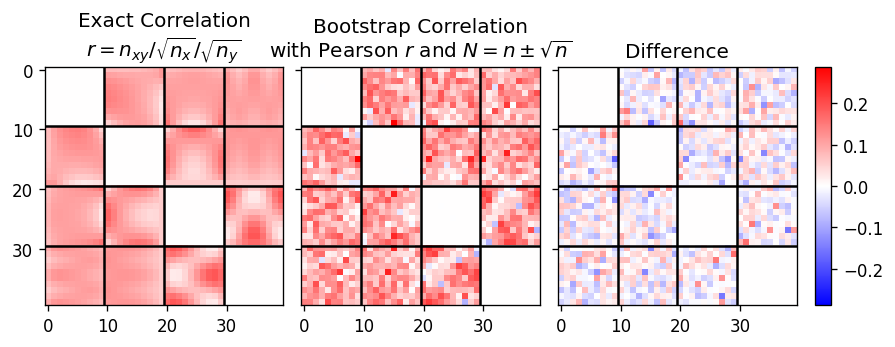

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid

vmin = min(np.min(bootstrap_correlation - np.identity(40)), np.min(exact_correlation - np.identity(40)))
vmax = max(np.max(bootstrap_correlation - np.identity(40)), np.max(exact_correlation - np.identity(40)))

vmax = max(abs(vmin), abs(vmax))
vmin = -vmax

fig = plt.figure(figsize=(9.75, 3), dpi=120)

axs = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
    
axs[0].imshow(exact_correlation - np.identity(40), vmin=vmin, vmax=vmax, cmap="bwr")
axs[0].axvline( 9.5, color="black")
axs[0].axvline(19.5, color="black")
axs[0].axvline(29.5, color="black")
axs[0].axhline( 9.5, color="black")
axs[0].axhline(19.5, color="black")
axs[0].axhline(29.5, color="black")
axs[0].set_title(f"Exact Correlation\n" + r"$r = n_{xy} / \sqrt{n_x} / \sqrt{n_y}$")

im = axs[1].imshow(bootstrap_correlation - np.identity(40), vmin=vmin, vmax=vmax, cmap="bwr")
axs[1].axvline( 9.5, color="black")
axs[1].axvline(19.5, color="black")
axs[1].axvline(29.5, color="black")
axs[1].axhline( 9.5, color="black")
axs[1].axhline(19.5, color="black")
axs[1].axhline(29.5, color="black")
axs[1].set_title("Bootstrap Correlation\n" + r"with Pearson $r$ and $N=n\pm\sqrt{n}$")

im = axs[2].imshow(exact_correlation - bootstrap_correlation, vmin=vmin, vmax=vmax, cmap="bwr")
axs[2].axvline( 9.5, color="black")
axs[2].axvline(19.5, color="black")
axs[2].axvline(29.5, color="black")
axs[2].axhline( 9.5, color="black")
axs[2].axhline(19.5, color="black")
axs[2].axhline(29.5, color="black")
axs[2].set_title(f"Difference")

axs[-1].cax.colorbar(im)
axs[-1].cax.toggle_label(True)
plt.tight_layout()
plt.show()

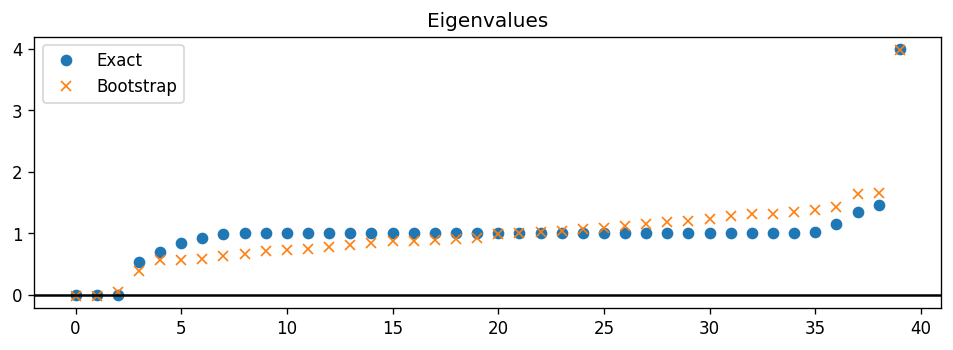

In [18]:
fig = plt.figure(figsize=(9.75, 3), dpi=120)

plt.plot(range(40), sorted(np.linalg.eigvals(exact_correlation)), ls="", marker="o", label="Exact")
plt.plot(range(40), sorted(np.linalg.eigvals(bootstrap_correlation)), ls="", marker="x", label="Bootstrap")
plt.axhline(0, color="black")
plt.title("Eigenvalues")
plt.legend()
plt.show()
plt.close()

In [19]:
t = theory(test)

In [20]:
t

array([1.09391454e-15, 1.72617597e-15, 1.93939379e-15, 2.02311179e-15,
       2.04752396e-15, 2.03196527e-15, 1.97230177e-15, 1.85119426e-15,
       1.64326123e-15, 1.31811093e-15, 2.38417227e-15, 2.37212541e-15,
       2.31297527e-15, 2.20672184e-15, 2.05336513e-15, 1.85290513e-15,
       1.60534184e-15, 1.31065748e-15, 9.68905405e-16, 5.80032258e-16,
       2.32996142e-15, 1.95313513e-15, 1.67051541e-15, 1.48210226e-15,
       1.38789569e-15, 1.38789569e-15, 1.48210226e-15, 1.67051541e-15,
       1.95313513e-15, 2.32996142e-15, 1.92586769e-15, 1.70316980e-15,
       1.56553493e-15, 1.70316980e-15, 1.92586769e-15, 1.92586769e-15,
       1.70316980e-15, 1.56553493e-15, 1.70316980e-15, 1.92586769e-15])

In [21]:
asimov_data = luminosity * eeToUpsilon4S_cross_section * UpsilonToCharged * 2 * efficiency * t * tauBplus

In [22]:
asimov_data = correlated_values_norm(
    [(x, x**0.5) for x in asimov_data],
    exact_correlation
)

In [23]:
asimov_data = tuple(x / (luminosity * eeToUpsilon4S_cross_section * UpsilonToCharged * 2 * efficiency * tauBplus) for x in asimov_data)

In [24]:
asimov_uncertainty = unp.std_devs(asimov_data)
asimov_covariance = exact_correlation * np.outer(asimov_uncertainty, asimov_uncertainty)
#asimov_covariance *= 1e15**2
asimov_covariance_inv = np.linalg.inv(asimov_covariance)
asimov_data = unp.nominal_values(asimov_data)
#asimov_data *= 1e15

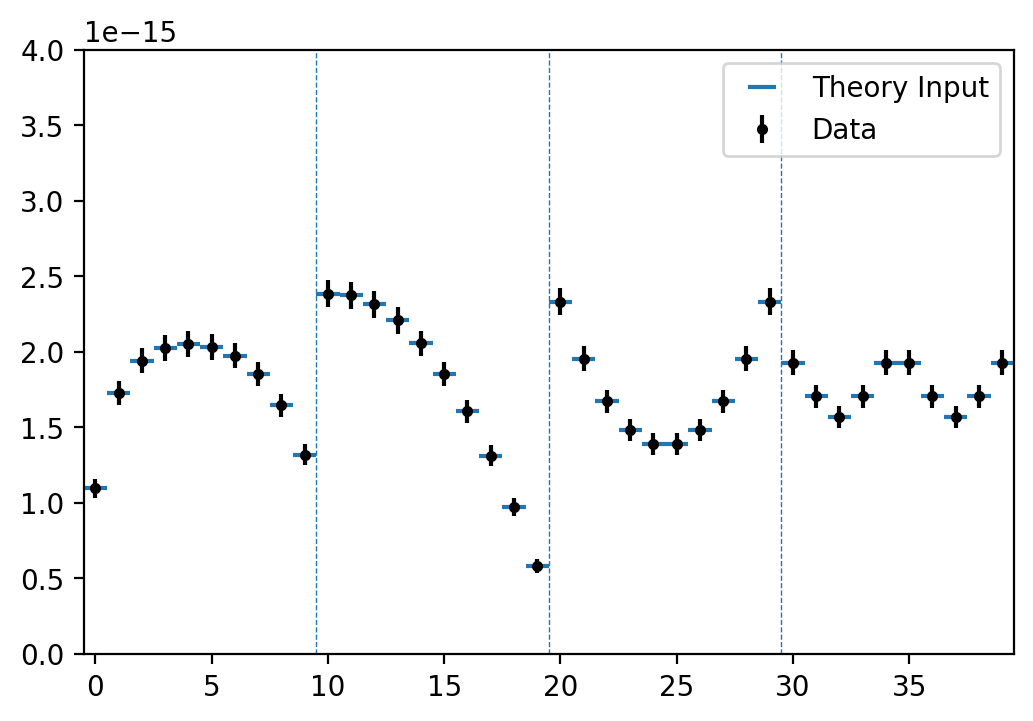

In [25]:
plt.figure(dpi=200)
plt.errorbar(range(40), t, xerr=0.5, ls="", marker="", color="tab:blue", label="Theory Input")
# plt.errorbar(range(40), f, xerr=0.5, ls="", marker="x", color="tab:orange", label="Theory Output")
plt.errorbar(range(40), asimov_data, yerr=asimov_covariance.diagonal()**0.5, ls="", marker=".", color="black", label="Data")

plt.axvline(9.5, ls="--", lw=0.5)
plt.axvline(19.5, ls="--", lw=0.5)
plt.axvline(29.5, ls="--", lw=0.5)
plt.xlim(-0.5, 39.5)
plt.ylim(0, 4e-15)
plt.legend()

If we check now our asimov data and just sum over it, we get four times the rate

In [26]:
sum(asimov_data) - 4. * rate.Gamma()

-2.8407741199283555e-19

### Transform to normalized magins

Normalize each marginal distribution.

In [27]:
def jac(x):
    return  np.diag([
        *np.ones(10) / sum(x[ 0:10]),
        *np.ones(10) / sum(x[10:20]),
        *np.ones(10) / sum(x[20:30]),
        *np.ones(10) / sum(x[30:40]),
    ])

asimov_data_normalized = jac(asimov_data) @ asimov_data
asimov_covariance_normalized = jac(asimov_data) @ asimov_covariance @ jac(asimov_data).transpose()

In [28]:
t_rate, t_normalized = theory_normalized(test)

This is everything after normalization. To now actually perform a fit, we remove the last bin in marginal distribution. The overall rate will be considered in an additional term in the $\chi^2$.

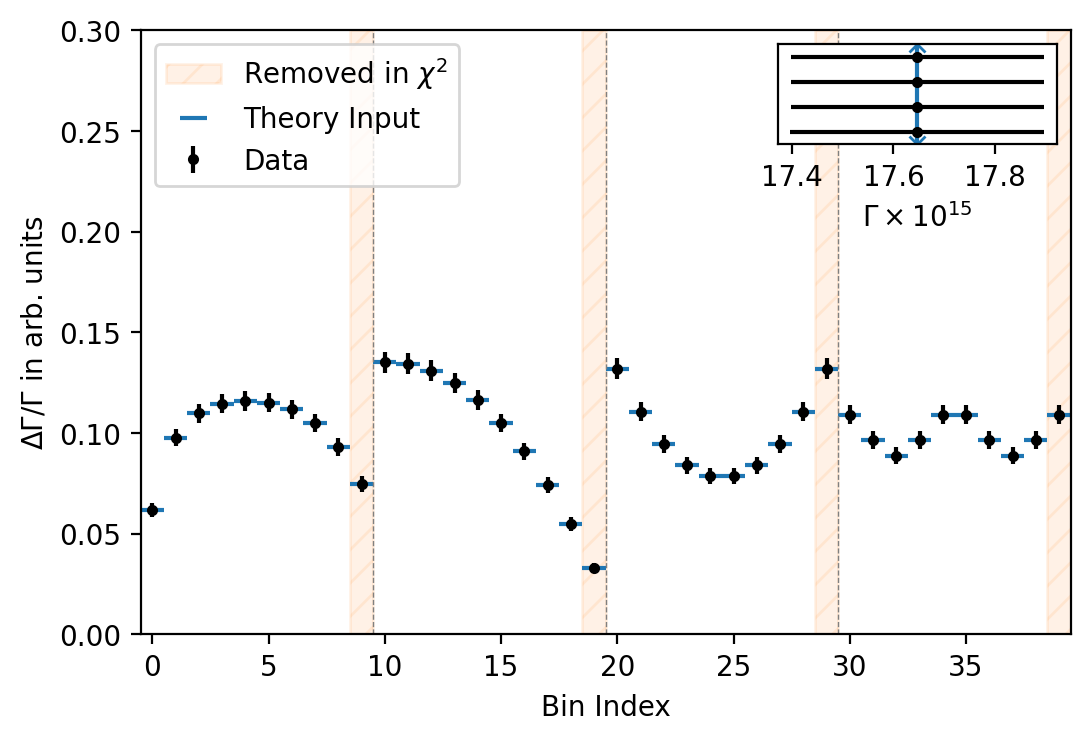

In [29]:
plt.figure(dpi=200)
ax = plt.gca()
ax.errorbar(range(40), t_normalized, xerr=0.5, ls="", marker="", color="tab:blue", label="Theory Input")
ax.errorbar(range(40), asimov_data_normalized, yerr=asimov_covariance_normalized.diagonal()**0.5, ls="", marker=".", color="black", label="Data")

ax.axvline( 9.5, ls="--", lw=0.5, color="grey")
ax.axvline(19.5, ls="--", lw=0.5, color="grey")
ax.axvline(29.5, ls="--", lw=0.5, color="grey")

ax.set_xlim(-0.5, 39.5)
ax.set_ylim(0, 0.3)
ax.set_xlabel(r"Bin Index")
ax.set_ylabel(r"$\Delta \Gamma / \Gamma$ in arb. units")
ax.fill_betweenx(np.array([0, 0, 0.3]),  8.5,  9.5, alpha=0.1, hatch="//", color="tab:orange")
ax.fill_betweenx(np.array([0, 0, 0.3]), 18.5, 19.5, alpha=0.1, hatch="//", color="tab:orange")
ax.fill_betweenx(np.array([0, 0, 0.3]), 28.5, 29.5, alpha=0.1, hatch="//", color="tab:orange")
ax.fill_betweenx(np.array([0, 0, 0.3]), 38.5, 39.5, alpha=0.1, hatch="//", color="tab:orange", label=r"Removed in $\chi^2$")

ax.legend(loc=2)


parent_axes = plt.gca()
inside_axis = inset_axes(parent_axes,
                    width="30%", # width = 30% of parent_bbox
                    height=0.5, # height : 1 inch
                    loc=1)

inside_axis.axvline(1e15*t_rate , 0, marker="x", color="tab:blue")
inside_axis.errorbar(1e15*sum(asimov_data[  :10]), 0, xerr=1e15*sum(asimov_covariance[  :10,   :10].diagonal()) ** 0.5,  marker=".", color="black")
inside_axis.errorbar(1e15*sum(asimov_data[10:20]), 1, xerr=1e15*sum(asimov_covariance[10:20, 10:20].diagonal()) ** 0.5,  marker=".", color="black")
inside_axis.errorbar(1e15*sum(asimov_data[20:30]), 2, xerr=1e15*sum(asimov_covariance[20:30, 20:30].diagonal()) ** 0.5,  marker=".", color="black")
inside_axis.errorbar(1e15*sum(asimov_data[30:40]), 3, xerr=1e15*sum(asimov_covariance[30:40, 30:40].diagonal()) ** 0.5,  marker=".", color="black")
#inside_axis.set_xlim(17, 18)
inside_axis.set_ylim(-0.5, 3.5)
#inside_axis.set_yticklabels([])
inside_axis.set_yticks([])
inside_axis.set_xlabel(r"$\Gamma \times 10^{15}$")

plt.show()
plt.close()

### The Fit

The $\chi^2$ function to determine the form factors $\vec{x}$ is then defined as:

$\chi^2(\vec{x}) = \chi^2_\mathrm{rate}(\vec{x}) + \chi^2_\mathrm{shape}(\vec{x})$, with

$\chi^2_\mathrm{rate}(\vec{x}) = \frac{(\Gamma_\mathrm{theory}(\vec{x}) - \Gamma_\mathrm{measused})^2}{\sigma^2(\Gamma_\mathrm{measused})} $, and 

$\chi^2_\mathrm{shape} = (\Delta\vec{\Gamma}_\mathrm{theory}(\vec{x}) - \Delta\vec{\Gamma}_\mathrm{measused})^T C^{-1} (\Delta\vec{\Gamma}_\mathrm{theory}(\vec{x}) - \Delta\vec{\Gamma}_\mathrm{measused}) $.

$\Delta\vec{\Gamma}$ denotes the normalized rates in all bins, and $\Gamma$ the total rate. 

The last bin is removed in each normalized marginal distribution, because it is 100% correlated to all other bins (otherwise $C$ is singular).

In [30]:
def theory_normalized_fit(x):
    abs_rate, shape = theory_normalized(x)
    shape = np.delete(shape, 39, axis=0)
    shape = np.delete(shape, 29, axis=0)
    shape = np.delete(shape, 19, axis=0)
    shape = np.delete(shape,  9, axis=0)
    return np.array([*shape, 1e15*abs_rate])

In [31]:
def transformation(x):
    return np.array([
        *x[ 0:  9] / sum(x[ 0:10]),
        *x[10: 19] / sum(x[10:20]),
        *x[20: 29] / sum(x[20:30]),
        *x[30: 39] / sum(x[30:40]),
        1e15*sum(x) / 4
    ])

In [32]:
def sub_jac(x):
    sub_jac = np.zeros((9, 10))
    for i in range(9):
        sub_jac[i, :] = -x[i] / sum(x) ** 2
    for i in range(9):  # Add additional term to diagonal
        sub_jac[i, i] += 1 / sum(x)
        
    return sub_jac

In [33]:
def jac_fit(x):
    jac = np.zeros((37, 40))
    
    jac[ 0: 9, 0:10] = sub_jac(x[ 0:10])
    jac[ 9:18,10:20] = sub_jac(x[10:20])
    jac[18:27,20:30] = sub_jac(x[20:30])
    jac[27:36,30:40] = sub_jac(x[30:40])
    jac[36, :] = 1e15*np.ones(40) / 4
    
    return jac

In [34]:
asimov_data_normalized_fit = transformation(asimov_data) # jac_fit(asimov_data) @ asimov_data
asimov_covariance_normalized_fit = jac_fit(asimov_data) @ asimov_covariance @ jac_fit(asimov_data).transpose()

In [35]:
asimov_covariance_normalized_fit[0, :]

array([ 1.17089497e-05, -1.22102701e-06, -1.37184866e-06, -1.43106738e-06,
       -1.44833556e-06, -1.43732997e-06, -1.39512643e-06, -1.30945988e-06,
       -1.16237648e-06, -2.78619237e-07, -2.97902682e-07, -2.86736565e-07,
       -2.45120887e-07, -1.73055646e-07, -7.05408447e-08,  6.24235184e-08,
        2.25837443e-07,  4.19700928e-07, -3.65394369e-07, -1.21798123e-07,
        6.08990617e-08,  1.82697185e-07,  2.43596246e-07,  2.43596246e-07,
        1.82697185e-07,  6.08990617e-08, -1.21798123e-07,  1.90415446e-07,
       -7.27322282e-08, -2.35366435e-07, -7.27322282e-08,  1.90415446e-07,
        1.90415446e-07, -7.27322282e-08, -2.35366435e-07, -7.27322282e-08,
       -4.64787510e-14])

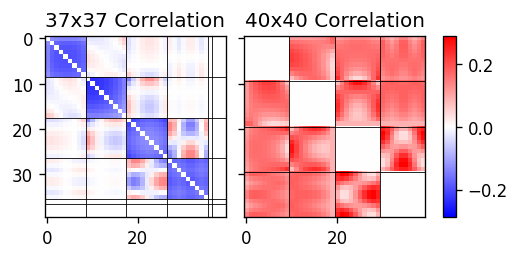

In [36]:
from mpl_toolkits.axes_grid1 import ImageGrid

asimov_correlation_normalized_fit = asimov_covariance_normalized_fit / np.outer(asimov_covariance_normalized_fit.diagonal() ** 0.5, asimov_covariance_normalized_fit.diagonal() ** 0.5)
asimov_correlation_normalized     = asimov_covariance_normalized / np.outer(asimov_covariance_normalized.diagonal() ** 0.5, asimov_covariance_normalized.diagonal() ** 0.5)

vmin = min(np.min(asimov_correlation_normalized_fit - np.identity(37)), np.min(asimov_correlation_normalized - np.identity(40)))
vmax = max(np.max(asimov_correlation_normalized_fit - np.identity(37)), np.max(asimov_correlation_normalized - np.identity(40)))

vmax = max(abs(vmin), abs(vmax))
vmin = -vmax

fig = plt.figure(figsize=(9.75, 2), dpi=120)

axs = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
    
axs[0].imshow(asimov_correlation_normalized_fit - np.identity(37), vmin=vmin, vmax=vmax, cmap="bwr")
axs[0].axvline( 8.5, color="black", lw=0.5)
axs[0].axvline(17.5, color="black", lw=0.5)
axs[0].axvline(26.5, color="black", lw=0.5)
axs[0].axvline(35.5, color="black", lw=0.5)
axs[0].axvline(36.5, color="black", lw=0.5)
axs[0].axhline( 8.5, color="black", lw=0.5)
axs[0].axhline(17.5, color="black", lw=0.5)
axs[0].axhline(26.5, color="black", lw=0.5)
axs[0].axhline(35.5, color="black", lw=0.5)
axs[0].axhline(36.5, color="black", lw=0.5)
axs[0].set_title(f"37x37 Correlation")
    
axs[1].imshow(asimov_correlation_normalized - np.identity(40), vmin=vmin, vmax=vmax, cmap="bwr")
axs[1].axvline( 9.5, color="black", lw=0.5)
axs[1].axvline(19.5, color="black", lw=0.5)
axs[1].axvline(29.5, color="black", lw=0.5)
axs[1].axhline( 9.5, color="black", lw=0.5)
axs[1].axhline(19.5, color="black", lw=0.5)
axs[1].axhline(29.5, color="black", lw=0.5)
axs[1].set_title(f"40x40 Correlation")

axs[-1].cax.colorbar(im)
axs[-1].cax.toggle_label(True)
plt.show()

In [37]:
asimov_correlation_normalized_fit[-1, :]

array([-5.42407853e-11, -4.39541423e-11, -2.06940908e-11,  1.53681809e-12,
        1.80293140e-11,  2.68904749e-11,  2.79818413e-11,  2.22412770e-11,
        1.10966506e-11,  1.53400756e-07,  1.47451469e-07,  1.17395583e-07,
        6.17008063e-08, -2.28317616e-08, -1.42088064e-07, -3.06991516e-07,
        1.99965300e-06, -1.09995364e-06,  3.49807814e-07,  7.82220860e-08,
       -4.57692002e-08, -1.96510450e-07, -2.78820865e-07, -2.78820865e-07,
       -1.96510450e-07, -4.57692000e-08,  7.82220861e-08, -1.63343654e-07,
        3.18488221e-08,  2.92102082e-07,  3.18488221e-08, -1.63343654e-07,
       -1.63343654e-07,  3.18488222e-08,  2.92102082e-07,  3.18488221e-08,
        1.00000000e+00])

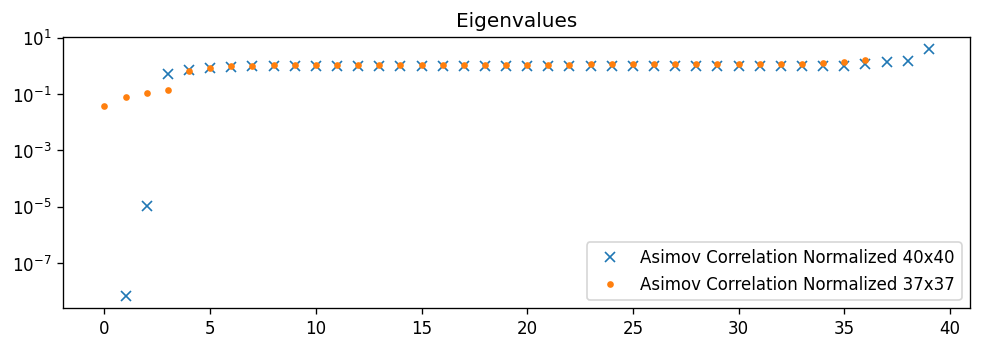

In [38]:
fig = plt.figure(figsize=(9.75, 3), dpi=120)
plt.plot(range(40), sorted(np.linalg.eigvals(asimov_correlation_normalized)), marker="x", ls="", label="Asimov Correlation Normalized 40x40")
plt.plot(range(37), sorted(np.linalg.eigvals(asimov_correlation_normalized_fit)), marker=".", ls="", label="Asimov Correlation Normalized 37x37")
plt.legend()
#plt.ylim(None, 0.2)
plt.title("Eigenvalues")
plt.yscale("log")
plt.show()

The inverse of this covariance matrix is proper, $C_{37x37}^{-1}C_{37x37} = 1$:

In [39]:
np.allclose(
    np.linalg.inv(asimov_covariance_normalized_fit) @ asimov_covariance_normalized_fit,
    np.identity(37)
)

True

In [40]:
t_normalized_fit = theory_normalized_fit(test)

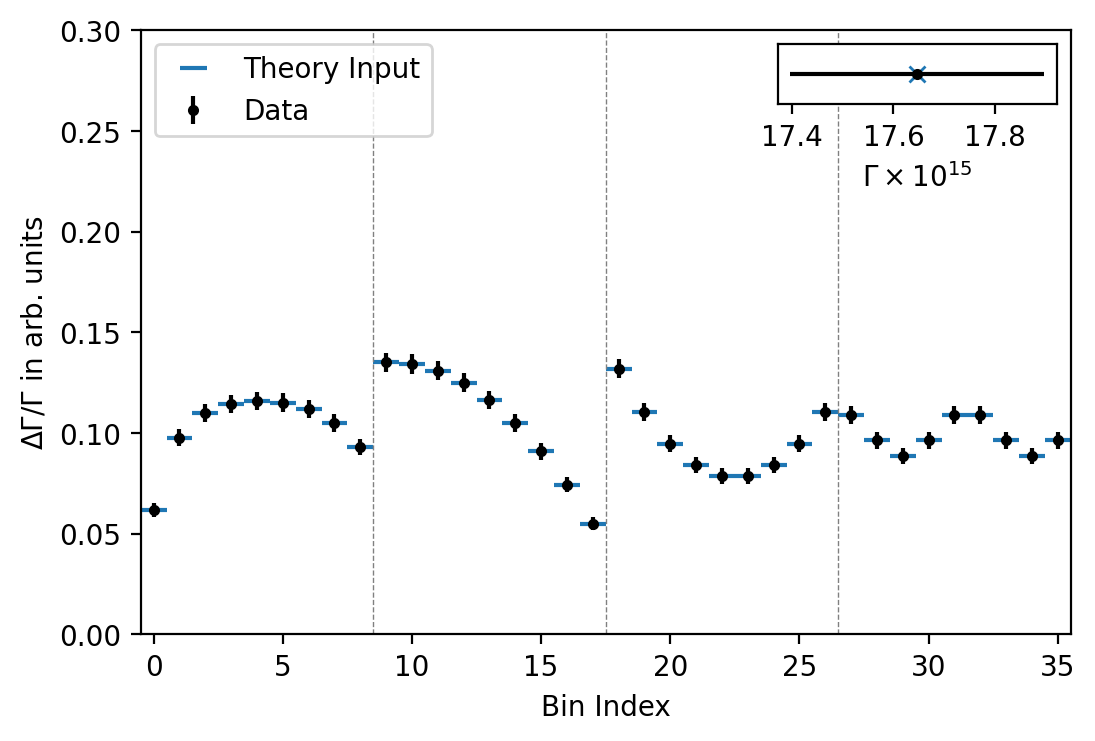

In [41]:
plt.figure(dpi=200)
ax = plt.gca()
ax.errorbar(range(36), t_normalized_fit[:-1], xerr=0.5, ls="", marker="", color="tab:blue", label="Theory Input")
ax.errorbar(range(36), asimov_data_normalized_fit[:-1], yerr=asimov_covariance_normalized_fit.diagonal()[:-1]**0.5, ls="", marker=".", color="black", label="Data")

ax.axvline( 8.5, ls="--", lw=0.5, color="grey")
ax.axvline(17.5, ls="--", lw=0.5, color="grey")
ax.axvline(26.5, ls="--", lw=0.5, color="grey")

ax.set_xlim(-0.5, 35.5)
ax.set_ylim(0, 0.3)
ax.set_xlabel(r"Bin Index")
ax.set_ylabel(r"$\Delta \Gamma / \Gamma$ in arb. units")

ax.legend(loc=2)


parent_axes = plt.gca()
inside_axis = inset_axes(parent_axes,
                    width="30%", # width = 30% of parent_bbox
                    height=0.3, # height : 1 inch
                    loc=1)

inside_axis.errorbar(t_normalized_fit[-1] , 0, marker="x", color="tab:blue")
inside_axis.errorbar(asimov_data_normalized_fit[-1], 0, xerr=asimov_covariance_normalized_fit.diagonal()[-1]**0.5,  marker=".", color="black")
inside_axis.set_ylim(-0.1, 0.1)
#inside_axis.set_yticklabels([])
inside_axis.set_yticks([])
inside_axis.set_xlabel(r"$\Gamma \times 10^{15}$")

plt.show()
plt.close()

In [42]:
asimov_covariance_normalized_fit_inv = np.linalg.inv(asimov_covariance_normalized_fit)

In [43]:
def chi2_normalized(x):
    delta = asimov_data_normalized_fit - theory_normalized_fit(x)
    return delta @ asimov_covariance_normalized_fit_inv @ delta

In [44]:
chi2_normalized(test)

1.4535637755466395e-05

In [45]:
test

array([ 0.0004,  0.03  ,  0.0005, -0.002 , -0.0004,  0.005 ])

In [46]:
%%time

fit_result = scipy.optimize.minimize(
    chi2_normalized,
    x0=test, method="SLSQP"
)

CPU times: user 7.56 s, sys: 0 ns, total: 7.56 s
Wall time: 7.56 s


In [47]:
import numdifftools

In [48]:
%%time
hesse = numdifftools.Hessian(chi2_normalized)(test)

fit_result.covariance = np.linalg.inv(hesse / 2)

CPU times: user 3min 38s, sys: 56.2 ms, total: 3min 38s
Wall time: 3min 39s


## Fit on Toy

In [50]:
data = np.array([
    *data_w,
    *data_cosL,
    *data_cosV,
    *data_chi
]) * 1e15

C = bootstrap_correlation * np.outer(unp.std_devs(data), unp.std_devs(data)) 
invC = np.linalg.inv(C)
data = unp.nominal_values(data)

In [51]:
t = theory(test)

# _, t_normalized = theory_normalized(test)

In [52]:
# %prun theory(test)

In [53]:
def chi2_absolute(x, data, invC):
    delta = theory(x) - data
    return delta @ invC @ delta


# def chi2_normalized(x):
#     rate, shape = theory_normalized(x)
#     delta_rate = rate - N_data
#     delta_shape = shape - data_normalized
#     return shape @ invC_normalized @ shape + delta_rate * inv_sigma_data * delta_rate

In [54]:
%%time
result_absolute = scipy.optimize.minimize(
    lambda x: chi2_absolute(x, data, invC),
    x0=test,
    method="SLSQP"
)

CPU times: user 1.5 s, sys: 254 µs, total: 1.5 s
Wall time: 1.51 s


In [55]:
result_absolute

     fun: 5203.830786656098
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.0004,  0.03  ,  0.0005, -0.002 , -0.0004,  0.005 ])

In [56]:
# %%time
# result_normalized = scipy.optimize.minimize(
#     lambda x: chi2_normalized(x),
#     x0=test,
#     method="SLSQP"
# )

In [57]:
# result_normalized

In [58]:
f = theory(result_absolute.x)

# _, f_normalized = theory_normalized(result_normalized.x)

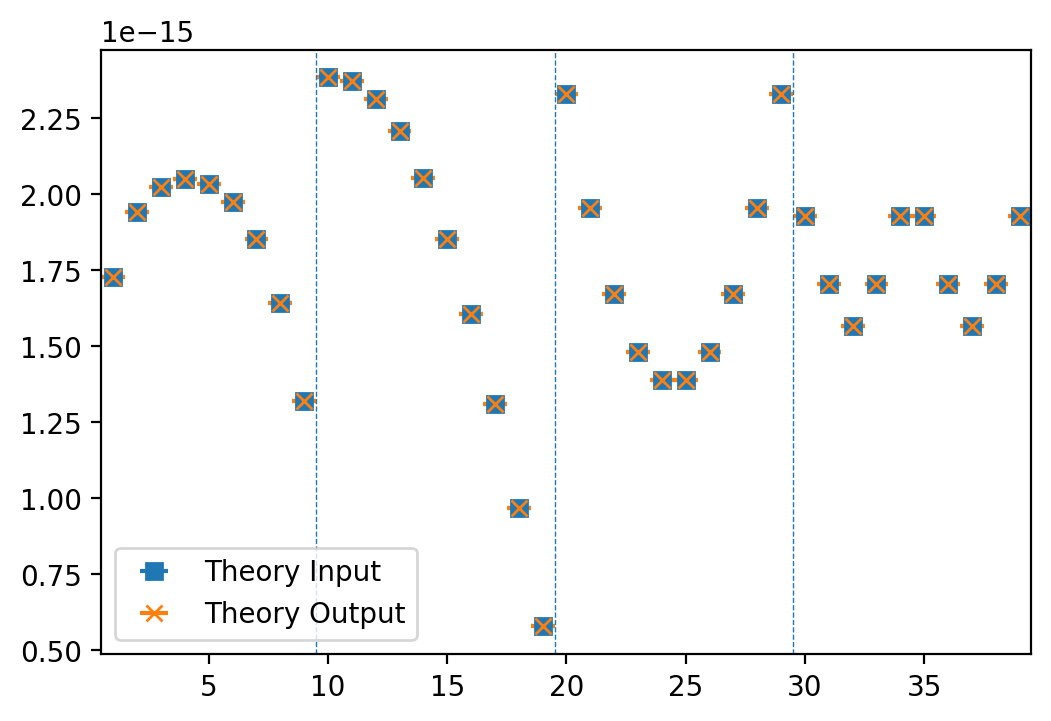

In [63]:
plt.figure(dpi=200)
plt.errorbar(range(40), t, xerr=0.5, ls="", marker="s", color="tab:blue", label="Theory Input")
plt.errorbar(range(40), f, xerr=0.5, ls="", marker="x", color="tab:orange", label="Theory Output")
#plt.errorbar(range(40), data, yerr=C.diagonal()**0.5, ls="", marker=".", color="black", label="Data")

plt.axvline(9.5, ls="--", lw=0.5)
plt.axvline(19.5, ls="--", lw=0.5)
plt.axvline(29.5, ls="--", lw=0.5)
plt.xlim(0.5, 39.5)
#plt.ylim(0, 5)
plt.legend()

In [60]:
t - f

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [61]:
# plt.figure(dpi=200)
# plt.errorbar(range(36), data_normalized, yerr=C_normalized.diagonal() ** 0.5, ls="", marker=".", color="black")
# plt.errorbar(range(36), t_normalized, xerr=0.5, ls="", marker="", color="tab:blue")
# plt.errorbar(range(36), f_normalized, xerr=0.5, ls="", marker="", color="tab:orange")
# plt.axvline(8.5, ls="--", lw=0.5)
# plt.axvline(17.5, ls="--", lw=0.5)
# plt.axvline(26.5, ls="--", lw=0.5)
# plt.xlim(0.5, 35.5)
# plt.ylim(0, 0.25)